In [19]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os
import numpy as np
import matplotlib.pyplot as plt

In [21]:
# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [22]:
# Paths
path = '/content/drive/MyDrive/DL_07_BONUS/animal_data'
train_path = '/content/drive/MyDrive/DL_07_BONUS/train'

In [23]:
#  Custom Dataset
class CustomImageDataset(Dataset):
    def __init__(self, path, transform=None):
        self.path = path
        self.folder_list = os.listdir(self.path)
        self.folder_path = [os.path.join(path, i) for i in self.folder_list]
        self.transform = transform
        self.image_paths = []
        self.image_paths_()

    def image_paths_(self):
        for i in self.folder_path:
            image_list = os.listdir(i)
            for j in image_list:
                self.image_paths.append(os.path.join(i, j))

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image

In [24]:
# Transform
transform = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])

dataset = CustomImageDataset(path=path, transform=transform)
train_dataset = CustomImageDataset(path=train_path, transform=transform)

batch_size = 5
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [25]:
# UNet
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        # Encoder
        self.max_pool = nn.MaxPool2d(2,2)
        self.layer_1 = nn.Sequential(nn.BatchNorm2d(3),
                                     nn.Conv2d(3,64,3,padding=1),
                                     nn.BatchNorm2d(64),
                                     nn.ReLU(inplace=True),
                                     nn.Conv2d(64,64,3,padding=1),
                                     nn.BatchNorm2d(64),
                                     nn.ReLU(inplace=True))
        self.layer_2 = nn.Sequential(nn.BatchNorm2d(64),
                                     nn.Conv2d(64,128,3,padding=1),
                                     nn.BatchNorm2d(128),
                                     nn.ReLU(inplace=True),
                                     nn.Conv2d(128,128,3,padding=1),
                                     nn.BatchNorm2d(128),
                                     nn.ReLU(inplace=True))
        self.layer_3 = nn.Sequential(nn.BatchNorm2d(128),
                                     nn.Conv2d(128,256,3,padding=1),
                                     nn.BatchNorm2d(256),
                                     nn.ReLU(inplace=True),
                                     nn.Conv2d(256,256,3,padding=1),
                                     nn.BatchNorm2d(256),
                                     nn.ReLU(inplace=True))
        self.layer_4 = nn.Sequential(nn.BatchNorm2d(256),
                                     nn.Conv2d(256,512,3,padding=1),
                                     nn.BatchNorm2d(512),
                                     nn.ReLU(inplace=True),
                                     nn.Conv2d(512,512,3,padding=1),
                                     nn.BatchNorm2d(512),
                                     nn.ReLU(inplace=True))
        self.layer_5 = nn.Sequential(nn.BatchNorm2d(512),
                                     nn.Conv2d(512,1024,3,padding=1),
                                     nn.BatchNorm2d(1024),
                                     nn.ReLU(inplace=True),
                                     nn.Conv2d(1024,1024,3,padding=1),
                                     nn.BatchNorm2d(1024),
                                     nn.ReLU(inplace=True))
        # Decoder
        self.up_conv_1 = nn.ConvTranspose2d(1024,512,2,2)
        self.layer_6 = nn.Sequential(nn.Conv2d(1024,512,3,padding=1),
                                     nn.BatchNorm2d(512),
                                     nn.ReLU(inplace=True),
                                     nn.Conv2d(512,512,3,padding=1),
                                     nn.BatchNorm2d(512),
                                     nn.ReLU(inplace=True))
        self.up_conv_2 = nn.ConvTranspose2d(512,256,2,2)
        self.layer_7 = nn.Sequential(nn.Conv2d(512,256,3,padding=1),
                                     nn.BatchNorm2d(256),
                                     nn.ReLU(inplace=True),
                                     nn.Conv2d(256,256,3,padding=1),
                                     nn.BatchNorm2d(256),
                                     nn.ReLU(inplace=True))
        self.up_conv_3 = nn.ConvTranspose2d(256,128,2,2)
        self.layer_8 = nn.Sequential(nn.Conv2d(256,128,3,padding=1),
                                     nn.BatchNorm2d(128),
                                     nn.ReLU(inplace=True),
                                     nn.Conv2d(128,128,3,padding=1),
                                     nn.BatchNorm2d(128),
                                     nn.ReLU(inplace=True))
        self.up_conv_4 = nn.ConvTranspose2d(128,64,2,2)
        self.layer_9 = nn.Sequential(nn.Conv2d(128,64,3,padding=1),
                                     nn.BatchNorm2d(64),
                                     nn.ReLU(inplace=True),
                                     nn.Conv2d(64,64,3,padding=1),
                                     nn.BatchNorm2d(64),
                                     nn.ReLU(inplace=True))
        self.layer_10 = nn.Sequential(nn.Conv2d(64,3,1),
                                      nn.BatchNorm2d(3),
                                      nn.Tanh())

    def forward(self, x):
        # Encoder
        x1 = self.layer_1(x)
        x2 = self.max_pool(x1)
        x3 = self.layer_2(x2)
        x4 = self.max_pool(x3)
        x5 = self.layer_3(x4)
        x6 = self.max_pool(x5)
        x7 = self.layer_4(x6)
        x8 = self.max_pool(x7)
        x9 = self.layer_5(x8)

        # Decoder with F.interpolate
        x10 = self.up_conv_1(x9)
        x10 = F.interpolate(x10, size=(x7.size(2), x7.size(3)))
        x11 = self.layer_6(torch.cat([x7, x10], dim=1))

        x12 = self.up_conv_2(x11)
        x12 = F.interpolate(x12, size=(x5.size(2), x5.size(3)))
        x13 = self.layer_7(torch.cat([x5, x12], dim=1))

        x14 = self.up_conv_3(x13)
        x14 = F.interpolate(x14, size=(x3.size(2), x3.size(3)))
        x15 = self.layer_8(torch.cat([x3, x14], dim=1))

        x16 = self.up_conv_4(x15)
        x16 = F.interpolate(x16, size=(x1.size(2), x1.size(3)))
        x17 = self.layer_9(torch.cat([x1, x16], dim=1))

        x18 = self.layer_10(x17)
        return x18

In [26]:
# Noise scheduler
t_steps = 50
beta_1 = 0.05
beta_2 = 0.25

In [27]:

def forward_pass(x, t_steps=t_steps, beta_1=beta_1, beta_2=beta_2):
    x = x.to(device)
    beta = torch.linspace(beta_1, beta_2, t_steps).to(device)
    alpha = 1 - beta
    alpha_hat = torch.cumprod(alpha, 0)
    t = torch.randint(0, t_steps, (1,), device=device)
    alpha_hat_t = alpha_hat[t].view(1,1,1,1)
    noise = torch.randn_like(x).to(device)
    x_noisy = torch.sqrt(alpha_hat_t) * x + torch.sqrt(1 - alpha_hat_t) * noise
    return x_noisy, noise, t

In [28]:

def backward_pass(x, t, model):
    x = x.to(device)
    t = t.to(device)
    beta = torch.linspace(beta_1, beta_2, t_steps).to(device)
    alpha = 1 - beta
    alpha_hat = torch.cumprod(alpha, 0)
    alpha_hat_t = alpha_hat[t].view(1,1,1,1)
    predicted_noise = model(x)
    x_prev = (x - torch.sqrt(1 - alpha_hat_t) * predicted_noise) / torch.sqrt(alpha_hat_t)
    return x_prev

Epoch 1 Train Loss: 0.6062 Test Loss: 0.9100
Epoch 2 Train Loss: 0.2828 Test Loss: 0.6981
Epoch 3 Train Loss: 0.2639 Test Loss: 0.4695
Epoch 4 Train Loss: 0.2466 Test Loss: 0.3190
Epoch 5 Train Loss: 0.2284 Test Loss: 0.2779
Epoch 6 Train Loss: 0.2239 Test Loss: 0.2695
Epoch 7 Train Loss: 0.2166 Test Loss: 0.2661
Epoch 8 Train Loss: 0.2235 Test Loss: 0.2414
Epoch 9 Train Loss: 0.2445 Test Loss: 0.2310
Epoch 10 Train Loss: 0.2114 Test Loss: 0.2363
Epoch 11 Train Loss: 0.2188 Test Loss: 0.2348
Epoch 12 Train Loss: 0.2060 Test Loss: 0.2293
Epoch 13 Train Loss: 0.2056 Test Loss: 0.2307
Epoch 14 Train Loss: 0.2184 Test Loss: 0.2206
Epoch 15 Train Loss: 0.2016 Test Loss: 0.2198
Epoch 16 Train Loss: 0.2120 Test Loss: 0.2150
Epoch 17 Train Loss: 0.1970 Test Loss: 0.2104
Epoch 18 Train Loss: 0.2251 Test Loss: 0.2377
Epoch 19 Train Loss: 0.2021 Test Loss: 0.2114
Epoch 20 Train Loss: 0.1992 Test Loss: 0.2145
Epoch 21 Train Loss: 0.2005 Test Loss: 0.2082
Epoch 22 Train Loss: 0.2087 Test Loss: 0.21

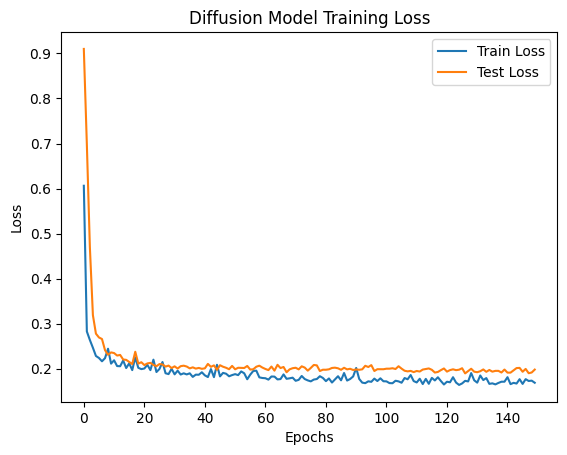

In [29]:
# Training setup
num_epochs = 150
lr = 0.001
model = UNet().to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
loss_fn = nn.MSELoss()

train_losses = []
test_losses = []

# Training loop
for epoch in range(num_epochs):
    model.train()
    epoch_loss = []
    for images in train_loader:
        images = images.to(device)
        optimizer.zero_grad()
        x_noisy, noise, t = forward_pass(images)
        predicted_noise = model(x_noisy)
        loss = loss_fn(predicted_noise, noise)
        loss.backward()
        optimizer.step()
        epoch_loss.append(loss.item())
    train_losses.append(np.mean(epoch_loss))

    model.eval()
    test_epoch_loss = []
    with torch.no_grad():
        for images in test_loader:
            images = images.to(device)
            x_noisy, noise, t = forward_pass(images)
            predicted_noise = model(x_noisy)
            loss = loss_fn(predicted_noise, noise)
            test_epoch_loss.append(loss.item())
    test_losses.append(np.mean(test_epoch_loss))

    print(f"Epoch {epoch+1} Train Loss: {train_losses[-1]:.4f} Test Loss: {test_losses[-1]:.4f}")

# Plot loss curves
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Diffusion Model Training Loss')
plt.legend()
plt.show()


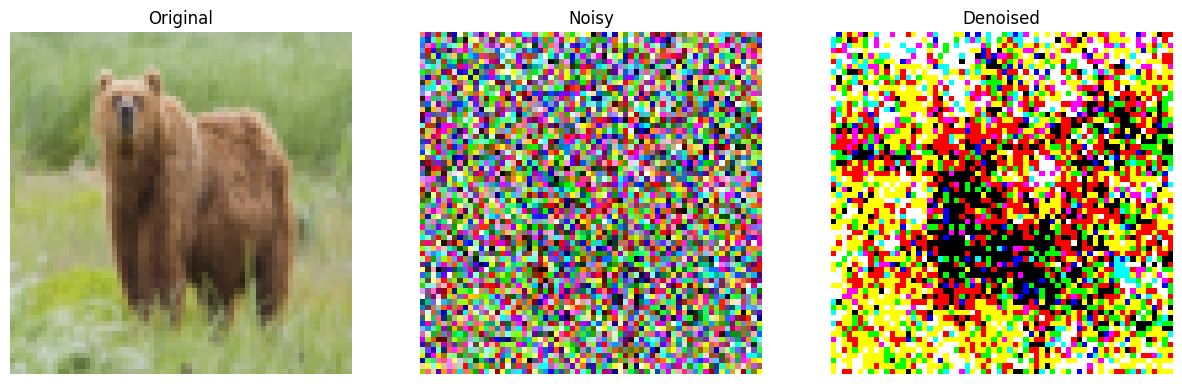

In [31]:
# --- Single Image Test and Visualization ---

from PIL import Image
import matplotlib.pyplot as plt
import torch

# Path to the test image
path = '/content/drive/MyDrive/DL_07_BONUS/train/bear/bear_1_1.jpg'

# Load and transform the image
img = Image.open(path).convert('RGB')
x = transform(img).unsqueeze(0).to(device)  # shape: (1, 3, H, W)

# Forward pass: add noise
# forward_pass expects a 4D batch input
noisy_image, noise, _ = forward_pass(x)

# Ensure noisy_image is 4D for model input
noisy_image = noisy_image.to(device)

# Backward pass: denoise step by step
# Backward pass with intermediate images for visualization
model.eval()
intermediate_imgs = []
with torch.no_grad():
    denoised_image = noisy_image  # initial input to reverse process
    for i in reversed(range(t_steps)):
        t_tensor = torch.full((1,), i, dtype=torch.long, device=device)
        denoised_image = backward_pass(denoised_image, t_tensor, model)
        # ensure 4D input for UNet
        if denoised_image.dim() == 3:
            denoised_image = denoised_image.unsqueeze(0)
        intermediate_imgs.append(denoised_image.clone())

# Convert tensors to displayable images
def tensor_to_image(tensor):
    tensor = tensor.squeeze(0).cpu().permute(1,2,0)  # (C,H,W) -> (H,W,C)
    tensor = tensor * 0.5 + 0.5  # unnormalize
    tensor = torch.clamp(tensor, 0, 1)
    return tensor.numpy()

orig = tensor_to_image(x)
noisy = tensor_to_image(noisy_image)
denoised = tensor_to_image(denoised_image)

# Plot original, noisy, and denoised images
fig, axes = plt.subplots(1,3, figsize=(15,5))

axes[0].imshow(orig)
axes[0].set_title('Original')
axes[0].axis('off')

axes[1].imshow(noisy)
axes[1].set_title('Noisy')
axes[1].axis('off')

axes[2].imshow(denoised)
axes[2].set_title('Denoised')
axes[2].axis('off')

plt.show()
